# 수행목표
- KMRD 데이터셋 국가, 출연배우 데이터를 확인하고 시각화한다.
# 수행단계
- 국가 탐색
    - 국가별 영화 개수를 확인하라. (Bar chart)
- 출연배우 탐색
    - 가장 많은 영화에 주연으로 출연한 배우를 찾아라.
    - 조연으로 가장 많은 영화에 출연한 배우를 찾아라.
    - 주연으로 출연한 영화(5편 이상 출연)들의 평균 평점이 가장 높은 영화(평점 10개 이상)의 주연 배우를 찾아라. (상위 3개 영화 등 조건을 변경할 수 있게 처리)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
movies = pd.read_csv('data/kmrd/movies.txt', sep='\t')  # 혹은 sep=','가 아니라 '\t'라면 tab 구분
rates = pd.read_csv('data/kmrd/rates.csv')
genres = pd.read_csv('data/kmrd/genres.csv')
castings = pd.read_csv('data/kmrd/castings.csv')
poeples = pd.read_csv('data/kmrd/peoples.txt', sep='\t')
countries = pd.read_csv('data/kmrd/countries.csv')

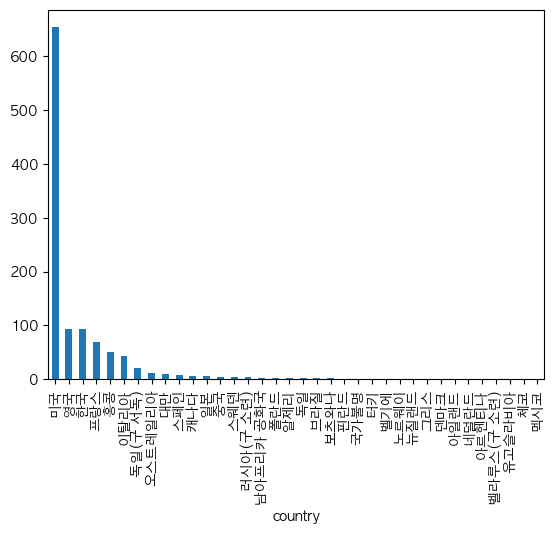

In [8]:
# 국가별 영화개수
movies_countries = pd.merge(movies, countries, on='movie')
movies_countries['country'].value_counts().plot(kind='bar')
# plt.xticks(rotation=45)
plt.show()

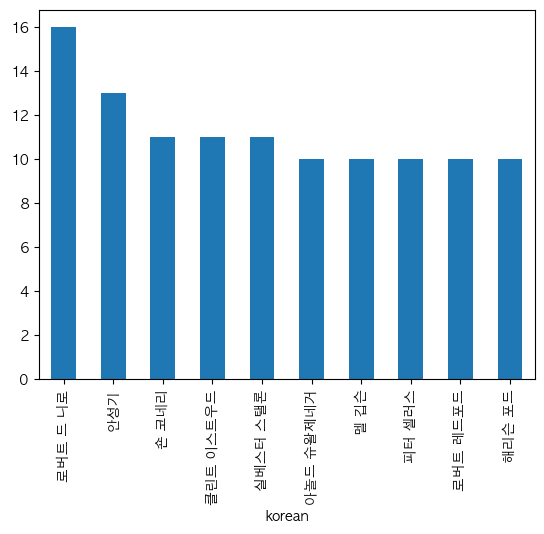

In [12]:
# 가장 많은 영화에 주연으로 출연한 배우
# castings 는 people의 leading이 1인 경우 주연

castings_people = pd.merge(castings, poeples, on='people')
castings_people = castings_people[castings_people['leading'] == 1]
castings_people['korean'].value_counts().head(10).plot(kind='bar')
plt.show()

<Axes: xlabel='korean'>

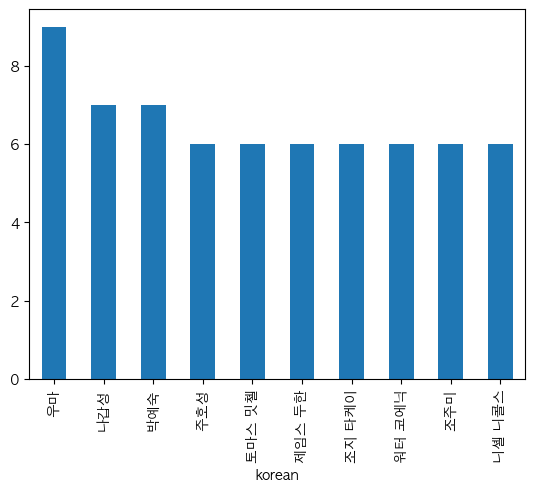

In [13]:
castings_people = pd.merge(castings, poeples, on='people')
castings_people = castings_people[castings_people['leading'] == 0]
castings_people['korean'].value_counts().head(10).plot(kind='bar')

In [19]:
# 주연으로 출연한 영화(5편 이상 출연)들의 평균 평점이 가장 높은 영화(평점 10개 이상)의 주연 배우를 찾아라. (상위 3개 영화 등 조건을 변경할 수 있게 처리)

def top_starring_actors_by_rating(
    castings, people, rates,
    min_ratings_per_movie=10,  # 영화당 최소 평점 개수
    min_leading_movies=5,      # 배우가 주연으로 출연한 최소 영화 수
    top_n=3                    # 상위 N명
):
    # 1) castings + people merge → 주연(leading=1)만 필터
    castings_people = pd.merge(castings, people, on='people', how='inner')
    castings_people = castings_people[castings_people['leading'] == 1]

    # 2) rates 에서 영화별 평점 개수, 평균
    movie_rating_stats = (
        rates.groupby('movie')['rate']
        .agg(['count', 'mean'])
        .rename(columns={'count': 'rating_count', 'mean': 'rating_mean'})
        .reset_index()
    )

    # 2-1) 평점 개수 >= min_ratings_per_movie 인 영화만 유효
    valid_movies = movie_rating_stats[
        movie_rating_stats['rating_count'] >= min_ratings_per_movie
    ].copy()

    # 3) 주연 배우 - 유효 영화 매핑
    #   → castings_people와 valid_movies를 영화 ID로 merge
    merged = pd.merge(
        castings_people, valid_movies,
        on='movie', how='inner'
    )
    # merged 데이터프레임에는
    #   movie, people, leading=1, korean(배우이름), rating_count, rating_mean

    # 4) 배우별로 '유효한 영화'들의 평균 평점을 다시 계산
    #   주연 배우가 출연한 유효 영화들의 rating_mean을 평균 내도 되고,
    #   혹은 각 영화에 대한 개별 평점을 다시 merge해서 배우별 '개별 평점' 평균을 낼 수도 있음.
    #   여기서는 valid_movies['rating_mean'] 자체의 평균을 사용 (즉, '각 영화의 평균 평점의 평균')
    actor_stats = (
        merged.groupby('korean')['movie']  # or 'people' ID
        .agg(['count'])                   # 주연으로 출연한 유효영화 편수
        .rename(columns={'count': 'valid_leading_count'})
        .reset_index()
    )
    # 배우별로 어떤 영화인지도 합쳐서 볼 필요가 있다면, groupby 후 .agg(list) 등으로 묶을 수 있음

    # 배우별 유효영화 평균평점을 구하려면 한 단계 더 merge/group 해줘야 함
    actor_rating = merged.groupby('korean')['rating_mean'].mean().reset_index()
    actor_rating.columns = ['korean', 'avg_rating_of_valid_movies']

    # 두 정보를 합쳐: (배우별 유효영화 편수), (배우별 유효영화 평균 평점)
    actor_merged = pd.merge(actor_stats, actor_rating, on='korean')

    # 5) "5편 이상 주연" 조건 적용
    filtered_actors = actor_merged[actor_merged['valid_leading_count'] >= min_leading_movies]

    # 6) 평균 평점이 높은 순으로 정렬 → 상위 N명
    top_actors = filtered_actors.sort_values(
        by='avg_rating_of_valid_movies',
        ascending=False
    ).head(top_n)

    return top_actors

In [20]:
result = top_starring_actors_by_rating(
    castings=castings,
    people=poeples,
    rates=rates,
    min_ratings_per_movie=10,
    min_leading_movies=5,
    top_n=3
)
result

,korean,valid_leading_count,avg_rating_of_valid_movies
790,찰리 채플린,5,9.302453
628,장국영,6,8.988466
157,로버트 드 니로,10,8.912423
